In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [33]:
class NeuralODE(nn.Module):
    def __init__(self, data_dim):
        super(NeuralODE, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, data_dim)
        )

    def forward(self, t, y):
        return self.net(y)

def train_one_round(model, optimizer, y0, t, y_true, max_iters):
    def loss_fn(y_pred, y_true):
        if not isinstance(y_true, torch.Tensor):
            y_true = torch.tensor(y_true, dtype=torch.float32)
        # loss
        return torch.mean((y_pred - y_true) ** 2)
    
    for iter in range(max_iters):
        optimizer.zero_grad()
        y0 = y0 if isinstance(y0, torch.Tensor) else torch.tensor(y0, dtype=torch.float32)
        t = t if isinstance(t, torch.Tensor) else torch.tensor(t, dtype=torch.float32)
        y_true = y_true if isinstance(y_true, torch.Tensor) else torch.tensor(y_true, dtype=torch.float32)
        
        # time span
        y_pred = odeint(model, y0, t)
        # loss
        loss = loss_fn(y_pred[-1], y_true)
        loss.backward()
        optimizer.step()
        print(f"Iter {iter+1}/{max_iters}, Loss: {loss.item()}")
    return model.parameters()

def load_data():
    file_path = './Datasets/DEMAND_DATA_SET_TEXAS.xlsx'
    df = pd.read_excel(file_path)
    return df

def preprocess(df):
    t = np.arange(len(df))
    data = df.iloc[:, list(range(14,21))]
    train = data.iloc[:-365]
    test = data.iloc[-365:]
    
    # t data
    t_train = np.arange(len(train))
    t_test = np.arange(len(test))
    y_train = train.values
    y_test = test.values

    # Scales
    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    t_train_scaled = scaler.fit_transform(t_train.reshape(-1, 1)).flatten()
    t_test_scaled = scaler.transform(t_test.reshape(-1, 1)).flatten()

    # Scales the feature data
    #y_scaler = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)
    return t_train_scaled, y_train_scaled, t_test_scaled, y_test_scaled, scaler

def train(t, y, obs_grid, maxiters, lr):
    data_dim = y.shape[1]
    model = NeuralODE(data_dim)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    for k in obs_grid:
        print(f"Training on first {k} observations...")
        y0 = torch.from_numpy(y[0, :]).float()
        t_span = torch.linspace(0, 1, steps=365)  # 365 steps for days in year
        train_one_round(model, optimizer, y0, t_span, y[:k], maxiters)
    return model

In [ ]:
df = load_data()
t_train, y_train, t_test, y_test, scaler = preprocess(df)
obs_grid = np.arange(365, len(t_train), 365)
maxiters = 50
lr = 5e-3
print(y_train.shape,y_test.shape)
model = train(t_train, y_train, obs_grid, maxiters, lr)
torch.save(model.state_dict(), 'fixmodel.pth')

(4748, 7) (365, 7)
Training on first 365 observations...
Iter 1/50, Loss: 0.10075870156288147
Iter 2/50, Loss: 0.06204362213611603
Iter 3/50, Loss: 0.04470013454556465
Iter 4/50, Loss: 0.041482992470264435
Iter 5/50, Loss: 0.044578343629837036
Iter 6/50, Loss: 0.04661912843585014
Iter 7/50, Loss: 0.04527478292584419
Iter 8/50, Loss: 0.042917653918266296
Iter 9/50, Loss: 0.041386086493730545
Iter 10/50, Loss: 0.040536921471357346
Iter 11/50, Loss: 0.039824649691581726
Iter 12/50, Loss: 0.03920740261673927
Iter 13/50, Loss: 0.03894856572151184
Iter 14/50, Loss: 0.03920654579997063
Iter 15/50, Loss: 0.03980006277561188
Iter 16/50, Loss: 0.04027632996439934
Iter 17/50, Loss: 0.040253955870866776
Iter 18/50, Loss: 0.039703406393527985
Iter 19/50, Loss: 0.03888943791389465
Iter 20/50, Loss: 0.03813064098358154
Iter 21/50, Loss: 0.03763168677687645
Iter 22/50, Loss: 0.03745672479271889
Iter 23/50, Loss: 0.037570007145404816
Iter 24/50, Loss: 0.037867382168769836
Iter 25/50, Loss: 0.0381947569

tensor([[0.7391, 0.8020, 0.1431, 0.5319, 0.7954, 0.4100, 0.2865]])
tensor([1.0000, 1.0002, 1.0004, 1.0006, 1.0008, 1.0011, 1.0013, 1.0015, 1.0017,
        1.0019, 1.0021, 1.0023, 1.0025, 1.0027, 1.0029, 1.0032, 1.0034, 1.0036,
        1.0038, 1.0040, 1.0042, 1.0044, 1.0046, 1.0048, 1.0051, 1.0053, 1.0055,
        1.0057, 1.0059, 1.0061, 1.0063, 1.0065, 1.0067, 1.0070, 1.0072, 1.0074,
        1.0076, 1.0078, 1.0080, 1.0082, 1.0084, 1.0086, 1.0088, 1.0091, 1.0093,
        1.0095, 1.0097, 1.0099, 1.0101, 1.0103, 1.0105, 1.0107, 1.0110, 1.0112,
        1.0114, 1.0116, 1.0118, 1.0120, 1.0122, 1.0124, 1.0126, 1.0129, 1.0131,
        1.0133, 1.0135, 1.0137, 1.0139, 1.0141, 1.0143, 1.0145, 1.0147, 1.0150,
        1.0152, 1.0154, 1.0156, 1.0158, 1.0160, 1.0162, 1.0164, 1.0166, 1.0169,
        1.0171, 1.0173, 1.0175, 1.0177, 1.0179, 1.0181, 1.0183, 1.0185, 1.0187,
        1.0190, 1.0192, 1.0194, 1.0196, 1.0198, 1.0200, 1.0202, 1.0204, 1.0206,
        1.0209, 1.0211, 1.0213, 1.0215, 1.0217, 1.021

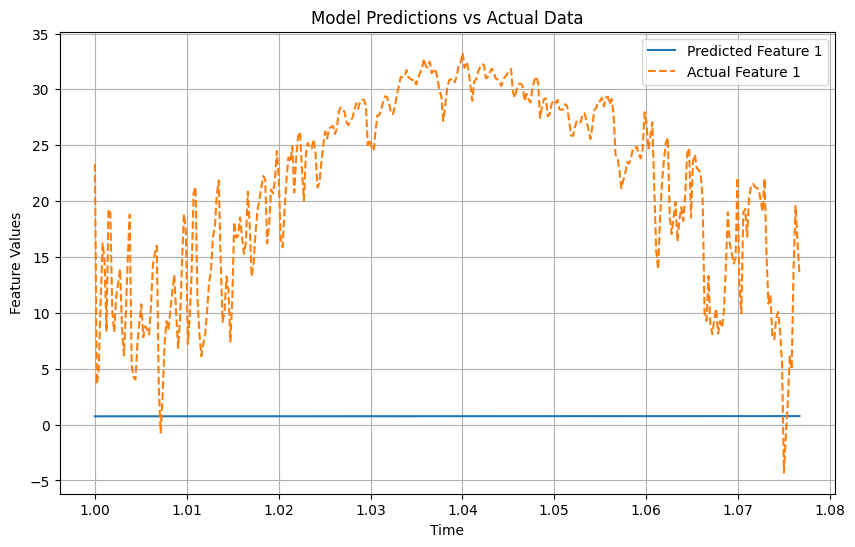

In [44]:
def plot_model_predictions(t_test_scaled, y_test_scaled, model, scaler):
    initial_condition = torch.from_numpy(y_test_scaled[0, :]).float().unsqueeze(0)
    print(initial_condition)
    t_span = torch.linspace(t_test_scaled[0], t_test_scaled[-1], len(t_test_scaled))
    #print(t_test_scaled)
    print(t_span)
    with torch.no_grad():
        predicted = odeint(model, initial_condition, t_span)
    
    # Convert predictions back to numpy and reshape (since the output will be [1, num_points, data_dim])
    predicted_np = predicted.squeeze().numpy()
    print(y_test_scaled.shape)
    #predicted_np = scaler.inverse_transform(predicted_np.reshape(-1, 1))
    #print(predicted_np)
    # Plot
    plt.figure(figsize=(10, 6))
    num_features = y_test_scaled.shape[1]
    for i in range(1):
        plt.plot(t_test_scaled.reshape(-1, 1).flatten(), predicted_np[:, i], label=f'Predicted Feature {i+1}')
        plt.plot(t_test_scaled.reshape(-1, 1).flatten(), scaler.inverse_transform(y_test_scaled)[:, i], label=f'Actual Feature {i+1}', linestyle='--')
    
    plt.title('Model Predictions vs Actual Data')
    plt.xlabel('Time')
    plt.ylabel('Feature Values')
    plt.legend()
    plt.grid(True)
    plt.show()

test_t_test = t_test+1
#test_y_test = y_test + 100
plot_model_predictions(test_t_test, y_test, model, scaler)
